In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sys  
sys.path.append("/Users/caihao/PycharmProjects/insight_project/")
from data.config import raw_data_dir, processed_data_dir, cleaned_data_dir
tweets_dir  = "/Users/caihao/Dropbox/TEMP/tweets/"

In [33]:
# test logistic regression model as baseline.
df = pd.read_csv(processed_data_dir + '/companies_all_labeled_final.csv')
selected_features = ['funding_total_usd', 'all_tweet_num',\
                     'preA_tweet_num', 'postA_tweet_num', 'preA_tweet_freq',\
                     'postA_tweet_freq', 'preA_tweet_avglength', 'postA_tweet_avglength',\
                     'preA_tweet_content_richness', 'postA_tweet_content_richness',\
                     'preA_tweet_interactiveness', 'postA_tweet_interactiveness',\
                     'status_feature', 'country_feature', 'age_feature',\
                     'days_since_first_funding', 'tweet_num_change', 'tweet_freq_change',\
                     'tweet_avglength_change', 'tweet_content_richness_change',\
                     'tweet_interactiveness_change', 'category_score', 'market_score',\
                     'tweets_pos_topic_score', 'tweets_neg_topic_score',\
                     'tweets_neg_sent_score', 'tweets_neu_sent_score',\
                     'tweets_pos_sent_score', 'tweets_compound_sent_score',\
                     'WILL',]
# selected_features = ['funding_total_usd', 'status_feature', 'country_feature', 'age_feature',\
#                      'days_since_first_funding', 'category_score', 'market_score',\
#                      'postA_tweet_num',\
#                      'postA_tweet_freq', 'postA_tweet_avglength',\
#                      'postA_tweet_content_richness',\
#                      'postA_tweet_interactiveness',\
#                      'tweets_pos_topic_score', 'tweets_neg_topic_score',\
#                      'tweets_neg_sent_score', 'tweets_neu_sent_score',\
#                      'tweets_pos_sent_score', 'tweets_compound_sent_score',\
#                      'WILL',]

new_df = df[selected_features].copy()
print(new_df.head())
X = new_df.iloc[:, :-1].values
y = new_df.iloc[:, -1].values
print(X.shape, y.shape)

   funding_total_usd  all_tweet_num  preA_tweet_num  postA_tweet_num  \
0              43811            551               0              551   
1            2800000           3473             303             3170   
2             383000            294               0              294   
3              33457            199              30              169   
4              80000           8792            8512              280   

   preA_tweet_freq  postA_tweet_freq  preA_tweet_avglength  \
0         0.000000          7.503891              0.000000   
1         5.810959         33.218563            108.669967   
2         0.000000          1.599068              0.000000   
3         6.000000          3.917219             86.000000   
4       163.692308          5.384615             87.731555   

   postA_tweet_avglength  preA_tweet_content_richness  \
0             113.822142                     0.000000   
1             115.986435                     0.019802   
2             100.49659

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2f49b2e8>,
      dtype=object)

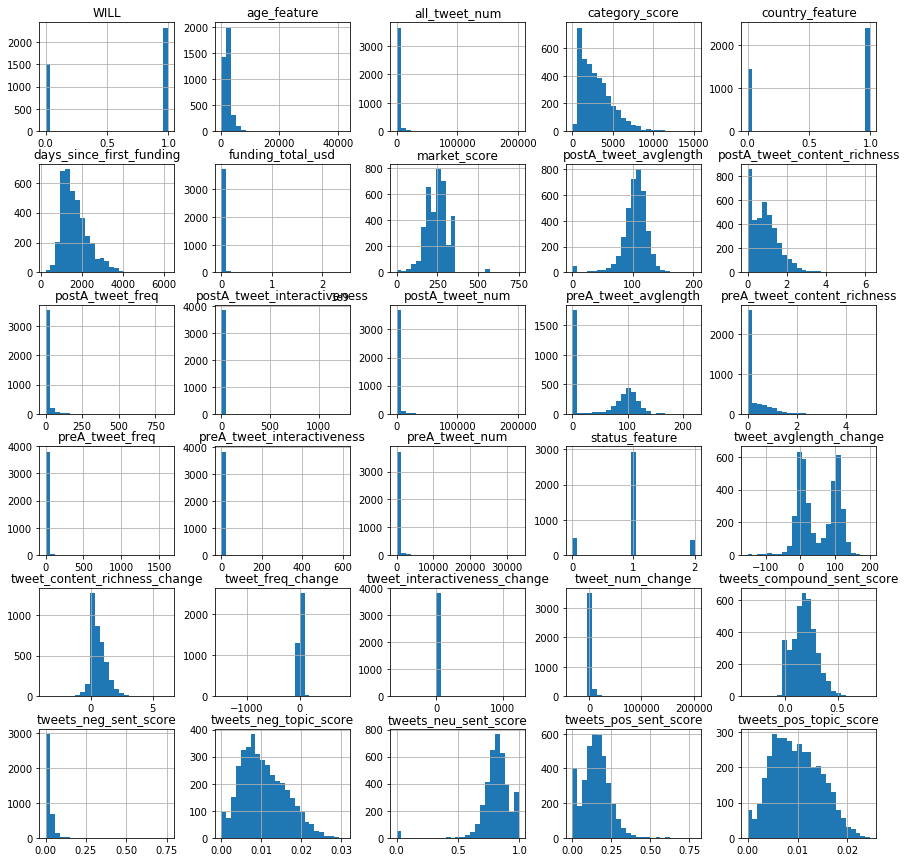

In [34]:
new_df.hist(bins=25, figsize=(15,15))

In [35]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

# logistic regression with cross-validation.
# clf = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial').fit(X, y)
clf = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=5
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=10
    )
clf.fit(X, y)


LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                         0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                         100000.0, 1000000.0, 10000000.0, 100000000.0,
                         1000000000.0],
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=777, refit=True, scoring='roc_auc',
                     solver='newton-cg', tol=10, verbose=0)

In [36]:
# look at important features.
print(pd.Series((np.std(X, 0)*clf.coef_)[0, :], index=selected_features[:-1]))

funding_total_usd                 6.117747
all_tweet_num                    76.859577
preA_tweet_num                    0.558788
postA_tweet_num                  69.524345
preA_tweet_freq                 -20.058792
postA_tweet_freq                -35.147651
preA_tweet_avglength             -0.190996
postA_tweet_avglength            -0.035495
preA_tweet_content_richness       0.082472
postA_tweet_content_richness      0.053074
preA_tweet_interactiveness       -0.218167
postA_tweet_interactiveness       0.112562
status_feature                    0.060138
country_feature                   0.198072
age_feature                      -0.175461
days_since_first_funding         -0.132748
tweet_num_change                 64.281831
tweet_freq_change               -21.045659
tweet_avglength_change            0.113731
tweet_content_richness_change    -0.063294
tweet_interactiveness_change      0.637799
category_score                    0.125905
market_score                      0.067548
tweets_pos_

In [37]:
# save trained model.
import pickle
processed_data_dir = '/Users/caihao/Dropbox/Insight_Jan2020/data/processed'
# with open(processed_data_dir + '/model_logreg_2.pkl', 'wb') as f:
#     pickle.dump(clf, f)

new_clf = pickle.load(open(processed_data_dir + '/model_logreg_2.pkl', 'rb'))
print(new_clf.predict(X))

[1 1 1 ... 0 1 1]


In [12]:
# Grid search for logistic model.
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X, y)

print('Best Penalty: ', best_model.best_estimator_.get_params()['penalty'])
print('Best C: ', best_model.best_estimator_.get_params()['C'])

Best Penalty:  l2
Best C:  10000.0


In [38]:
# The above code finds the values for Best penalty as ‘xxx’ and best C is ‘xxx’.
# Now let’s use these values and calculate the accuracy.
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import SCORERS

# all scoring metrics
# print(sorted(SCORERS.keys()))

# cross-validation.
kfold = KFold(n_splits=5, random_state=7)
model = LogisticRegression(C=1, penalty='l2')
result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
print("Accuracy: ", result.mean())

Accuracy:  0.7873693276814213


In [39]:
# Random forest model.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X[:, 1:], y, test_size=0.3, random_state=10)

# Create the model with 100 trees
clf = RandomForestClassifier(max_depth=5, n_estimators=20, random_state=7, oob_score=True)
clf.fit(X_train, y_train)

# Accuracy
print("Accuracy: ", clf.score(X_test, y_test))
print("OOB score: ", clf.oob_score_)

# feature importances.
print(pd.Series(clf.feature_importances_, index=selected_features[1:-1]))

Accuracy:  0.8554112554112554
OOB score:  0.8283803863298663
all_tweet_num                    0.070170
preA_tweet_num                   0.006017
postA_tweet_num                  0.137715
preA_tweet_freq                  0.022275
postA_tweet_freq                 0.058020
preA_tweet_avglength             0.009953
postA_tweet_avglength            0.007588
preA_tweet_content_richness      0.003527
postA_tweet_content_richness     0.022256
preA_tweet_interactiveness       0.002886
postA_tweet_interactiveness      0.075755
status_feature                   0.005783
country_feature                  0.015291
age_feature                      0.015976
days_since_first_funding         0.088993
tweet_num_change                 0.201107
tweet_freq_change                0.028976
tweet_avglength_change           0.021211
tweet_content_richness_change    0.028871
tweet_interactiveness_change     0.056169
category_score                   0.005345
market_score                     0.004666
tweets_pos_topi

In [40]:
# save trained model.
import pickle
processed_data_dir = '/Users/caihao/Dropbox/Insight_Jan2020/data/processed'
# with open(processed_data_dir + '/model_rf.pkl', 'wb') as f:
#     pickle.dump(clf, f)

new_clf = pickle.load(open(processed_data_dir + '/model_rf.pkl', 'rb'))
print(new_clf.predict(X_test))

[0 0 0 ... 0 1 0]


In [41]:
# XGBoost model.
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# split training feature and target sets into training and validation subsets
from sklearn.model_selection import train_test_split
X_train_sub, X_validation_sub, y_train_sub, y_validation_sub = train_test_split(X_train_scale, y_train, random_state=0)

# import machine learning algorithms
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# train with Gradient Boosting algorithm
# compute the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train_sub, y_train_sub)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_sub, y_train_sub)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation_sub, y_validation_sub)))
    print()
    
# Output confusion matrix and classification report of Gradient Boosting algorithm on validation set
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 1.0, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train_sub, y_train_sub)
predictions = gb.predict(X_validation_sub)
print("Confusion Matrix:")
print(confusion_matrix(y_validation_sub, predictions))
print()
print("Classification Report")
print(classification_report(y_validation_sub, predictions))

# ROC curve and Area-Under-Curve (AUC)
y_scores_gb = gb.decision_function(X_validation_sub)
fpr_gb, tpr_gb, _ = roc_curve(y_validation_sub, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

# feature importances.
print(pd.Series(gb.feature_importances_, index=selected_features[1:-1]))

Learning rate:  0.05
Accuracy score (training): 0.737
Accuracy score (validation): 0.710

Learning rate:  0.1
Accuracy score (training): 0.792
Accuracy score (validation): 0.741

Learning rate:  0.25
Accuracy score (training): 0.838
Accuracy score (validation): 0.798

Learning rate:  0.5
Accuracy score (training): 0.875
Accuracy score (validation): 0.811

Learning rate:  0.75
Accuracy score (training): 0.894
Accuracy score (validation): 0.823

Learning rate:  1
Accuracy score (training): 0.895
Accuracy score (validation): 0.845

Learning rate:  2
Accuracy score (training): 0.584
Accuracy score (validation): 0.579

Learning rate:  5
Accuracy score (training): 0.628
Accuracy score (validation): 0.614

Learning rate:  10
Accuracy score (training): 0.384
Accuracy score (validation): 0.377

Confusion Matrix:
[[218  47]
 [ 57 351]]

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       265
           1       0.88      0

In [42]:
# save trained model.
import pickle
processed_data_dir = '/Users/caihao/Dropbox/Insight_Jan2020/data/processed'
# with open(processed_data_dir + '/model_xgb.pkl', 'wb') as f:
#     pickle.dump(clf, f)

new_clf = pickle.load(open(processed_data_dir + '/model_xgb.pkl', 'rb'))
print(new_clf.predict(X_test))

[0 0 0 ... 0 1 0]
